### Import libraries

In [41]:
import pandas as pd
import seaborn as sns
from utils.data_utils import connect_to_db

### Connect to Database

In [42]:
engine, inspector, tables_in_db = connect_to_db()
print(f"Available tables: {tables_in_db}")

INFO:root:SQL engine is created.
INFO:root:2 tables found inside database viabill.db


Available tables: ['customers', 'transactions']


### Load extension for SQL queries

In [3]:
%load_ext sql

In [4]:
%sql sqlite:///data/viabill.db

### Make sure we can query tables with SQL

In [5]:
%%sql
SELECT * FROM customers
LIMIT 5

 * sqlite:///data/viabill.db
Done.


customerID,sex,age,residentialAddress,postalAddress,income
1,1,25,28 Irvine Place,28 Irvine Place,None
2,1,19,72 Bertha Street,72 Bertha Street,43200
3,2,22,63 Ladberry Street,63 Ladberry Street,70200
4,0,24,98 Linneman Close,98 Linneman Close,93900
5,1,53,56 Salonica Road,56 Salonica Road,77000


In [6]:
%%sql
SELECT count(*), count(distinct customerID) FROM customers

 * sqlite:///data/viabill.db
Done.


count(*),count(distinct customerID)
500000,500000


In [7]:
%%sql
SELECT * FROM transactions
LIMIT 5

 * sqlite:///data/viabill.db
Done.


transactionID,shopID,customerID,price,paytmentStatus1,paytmentStatus2,paytmentStatus3,paytmentStatus4
1,114,2869,140,0,0,0,0
2,855,124077,70,0,0,0,0
3,752,86184,85,0,0,0,0
4,246,248861,43,1,0,0,0
5,973,162112,127,0,0,0,0


### Task 1 and 2

**1.Select transactions that you use as credit applications (write SQL query):**
    
a. select the last transaction (transactionID increases with time) for each customer in Transaction table <br>
b. join result from previous point with customer Income - if Income is Missing replace it with -999 value

**2.Create a new feature based on transaction data - using Python or/and SQL:**

a. create “trans_price_avg_lst3” – for credit applications (transactions selected in point 1)
calculate a value that present an average price of 3 previous transactions

In [21]:
%%sql
WITH last_transaction as (
        SELECT customerID, max(transactionID) as last_transactionID
        FROM transactions
        GROUP BY customerID
),

last_three_transactions as (
        SELECT t.*, avg(price) OVER (PARTITION BY t.customerID ORDER BY transactionID ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) as trans_price_avg_lst3
        FROM transactions t
)

SELECT  t.*, 
        CASE WHEN cust.income is null then -999 else cust.income end as income
        
FROM last_three_transactions t
INNER JOIN last_transaction lt
    ON t.customerID = lt.customerID AND t.transactionID = lt.last_transactionID
INNER JOIN customers cust
    ON t.customerID = cust.customerID
ORDER BY t.customerID
LIMIT 10

 * sqlite:///data/viabill.db
Done.


transactionID,shopID,customerID,price,paytmentStatus1,paytmentStatus2,paytmentStatus3,paytmentStatus4,trans_price_avg_lst3,income
1697842,248,1,147,0,0,0,0,119.33333333333333,-999
1834257,392,2,150,0,0,0,0,98.33333333333333,43200
1974624,396,3,140,0,0,0,0,114.33333333333333,70200
1536291,544,4,136,0,1,0,0,None,93900
661121,984,5,181,0,0,0,0,64.33333333333333,77000
1964705,533,6,33,0,0,0,0,190.0,77500
313094,759,7,195,0,0,0,0,None,13600
1848871,123,9,31,0,0,0,0,105.5,2700
1854937,461,10,5,0,0,0,2,90.33333333333333,80000
696173,447,11,42,0,0,0,0,133.5,57000


*NOTE:* Both tasks were done in one query. Notice, that `trans_price_avg_lst3` may contain None values, which means that for this customerIDs the last transaction is actually the  first one. That's why we can not calculate average value of three previous transactions, as there are no such. Additional suggestion may be to round values to 2 decimals.

### Task 3

Check if there is a dependency between age and sex in the data – use statistical test if applicable.

To check the dependancy between two variables we may check correlation between them and in our case plot a distribution of `Age` depending on `Sex`. For simplicity I'll read `customers` table with Pandas.

In [27]:
customers = pd.read_sql_table("customers", con=engine)
print(customers.shape)
customers.head(3)

(500000, 6)


,customerID,sex,age,residentialAddress,postalAddress,income
0,1,1,25,28 Irvine Place,28 Irvine Place,NaN
1,2,1,19,72 Bertha Street,72 Bertha Street,43200.0
2,3,2,22,63 Ladberry Street,63 Ladberry Street,70200.0


In [29]:
# fast data types check
customers.dtypes

customerID              int64
sex                     int64
age                     int64
residentialAddress     object
postalAddress          object
income                float64
dtype: object

In [30]:
# fast missing check
customers.isnull().sum()

customerID               0
sex                      0
age                      0
residentialAddress       0
postalAddress            0
income                9975
dtype: int64

In [32]:
# basic stats
customers[["age", "sex"]].describe()

,age,sex
count,500000.000000,500000.000000
mean,44.630508,1.150402
std,16.178283,0.477797
min,5.000000,0.000000
25%,27.000000,1.000000
50%,50.000000,1.000000
75%,58.000000,1.000000
max,90.000000,2.000000


Correlation seems to be not high.

In [33]:
customers[["age", "sex"]].corr(method="spearman")

,age,sex
age,1.000000,0.001564
sex,0.001564,1.000000


As we may see the distribution of `Age` for differenct `Sex` levels is almost the same. So, **seems like there is no dependancy between age and sex in the data.** But, worth noticing, there is some strange gap sowhere in between 20 and 60 years old. For some reason people of average age tend to not use ViaBill services.

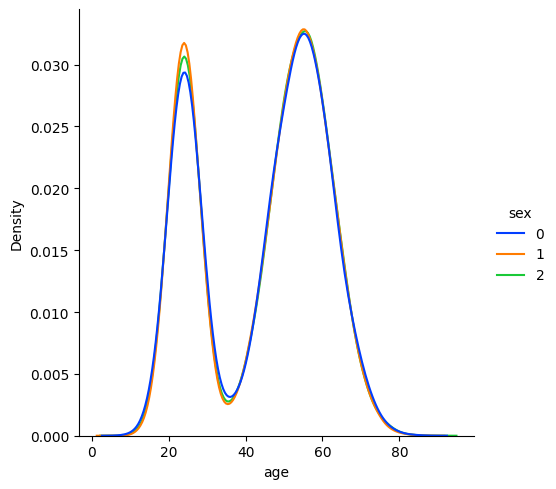

In [61]:
sns.displot(customers, x="age", hue="sex", kind="kde", common_norm=False, palette=sns.color_palette("bright", 3));